In [263]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

%matplotlib inline

In [264]:
def convert_to_float(value):        
    if "K" in value:
        return float(value[:-1]) * 1000
    if "M" in value:
        return float(value[:-1]) * 1000000
    if "B" in value:
        return float(value[:-1]) * 1000000000
    if "%" in value:
        return float(value[:-1]) / 100
    if value == "-":
        return None
    return float(value.replace(",", ""))

In [265]:
def test_stationarity(data):
    print("Dicky Fuller Test Results:")
    results = adfuller(data, autolag="AIC")
    output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))
    print(output)

In [266]:
ether_data = pd.read_csv("Datasets/ETH-USD-Data.csv")
ether_data.rename(columns={"Price": "Close", "Vol.": "Volume", "Change %": "Change"}, inplace=True)
ether_data["Date"] = ether_data['Date'].astype("datetime64")
for column in ether_data.columns[1:]:
    ether_data[column] = ether_data[column].apply(convert_to_float)
ether_data = ether_data.reindex(columns=["Date", "Open", "High", "Low", "Close", "Volume", "Change"]).set_index("Date").sort_values("Date")
ether_data = ether_data.interpolate()
ether_data_close = ether_data.drop(columns=ether_data.columns[:3].append(ether_data.columns[4:]))
# ether_data_close = ether_data["Close"]

In [267]:
ether_data_close

,Close
Date,
2016-03-10,11.75
2016-03-11,11.95
2016-03-12,12.92
2016-03-13,15.07
2016-03-14,12.50
...,...
2022-05-05,2747.46
2022-05-06,2692.88
2022-05-07,2636.03


In [268]:
ether_data_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2252 entries, 2016-03-10 to 2022-05-09
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2252 non-null   float64
dtypes: float64(1)
memory usage: 35.2 KB


In [269]:
ether_data_close.describe()

,Close
count,2252.000000
mean,813.961607
std,1163.604697
min,6.700000
25%,135.460000
50%,258.900000
75%,759.147500
max,4808.380000


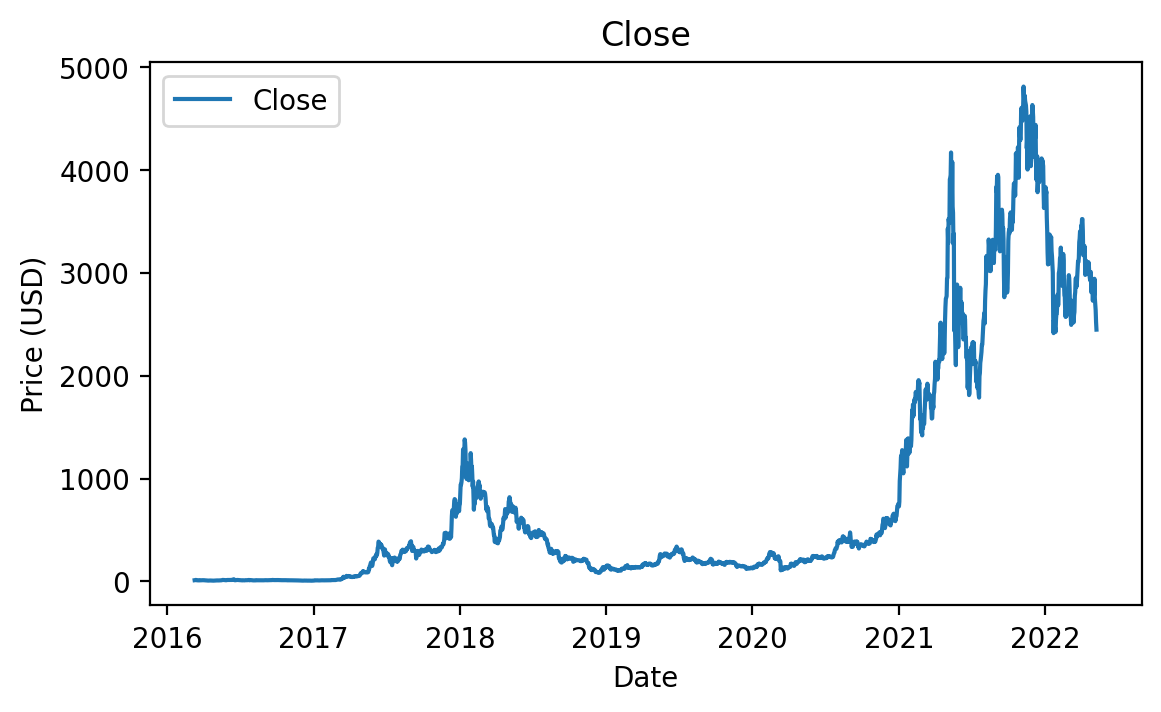

In [270]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data_close["Close"], label="Close")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Close")
plt.show()

In [271]:
test_stationarity(ether_data_close["Close"])

Dicky Fuller Test Results:
Statistics                -0.942825
p-value                    0.773543
Lags                      22.000000
Observations            2229.000000
Critical Value (1%)       -3.433287
Critical Value (5%)       -2.862838
Critical Value (10%)      -2.567461
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_13516\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


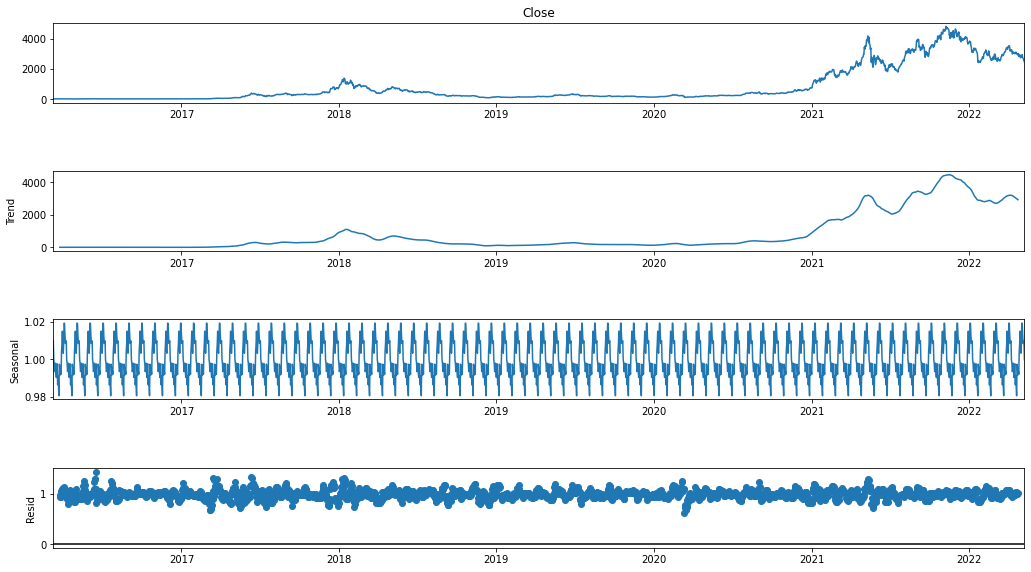

In [272]:
result = seasonal_decompose(ether_data_close["Close"], model="multiplicative", period=30)
result.plot().set_size_inches(16, 9)
plt.show()

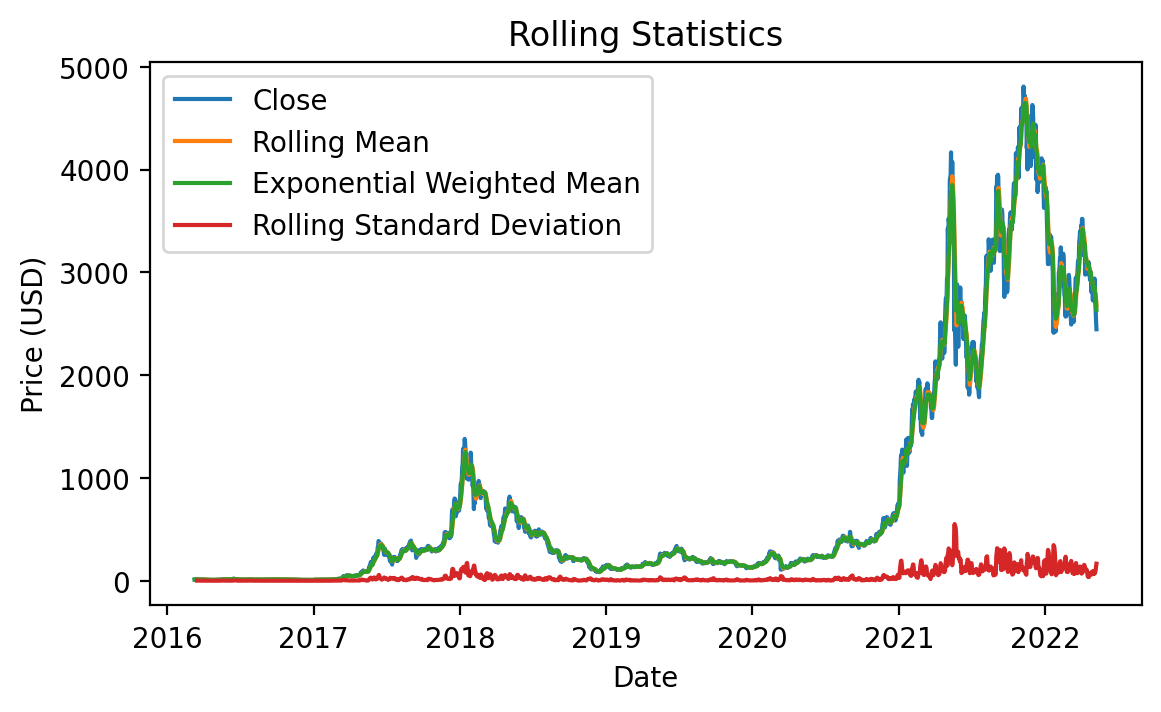

In [273]:
rolling_mean = ether_data_close.rolling(window=7).mean().dropna()
exp_w_mean = ether_data_close.ewm(span=7).mean()
rolling_std = ether_data_close.rolling(window=7).std().dropna()
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(ether_data_close["Close"], label="Close")
plt.plot(rolling_mean, label="Rolling Mean")
plt.plot(exp_w_mean, label="Exponential Weighted Mean")
plt.plot(rolling_std, label="Rolling Standard Deviation")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Rolling Statistics")
plt.show()

In [274]:
test_stationarity(rolling_mean)

Dicky Fuller Test Results:
Statistics                -1.207228
p-value                    0.670479
Lags                      27.000000
Observations            2218.000000
Critical Value (1%)       -3.433302
Critical Value (5%)       -2.862844
Critical Value (10%)      -2.567464
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_13516\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [275]:
test_stationarity(exp_w_mean)

Dicky Fuller Test Results:
Statistics                -1.064891
p-value                    0.728868
Lags                      21.000000
Observations            2230.000000
Critical Value (1%)       -3.433286
Critical Value (5%)       -2.862837
Critical Value (10%)      -2.567460
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_13516\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [276]:
diff_rolling_mean = (ether_data_close - rolling_mean).dropna()
diff_rolling_mean

,Close
Date,
2016-03-16,0.004286
2016-03-17,-1.991429
2016-03-18,-1.818571
2016-03-19,-1.875714
2016-03-20,-1.307143
...,...
2022-05-05,-66.151429
2022-05-06,-103.048571
2022-05-07,-146.877143


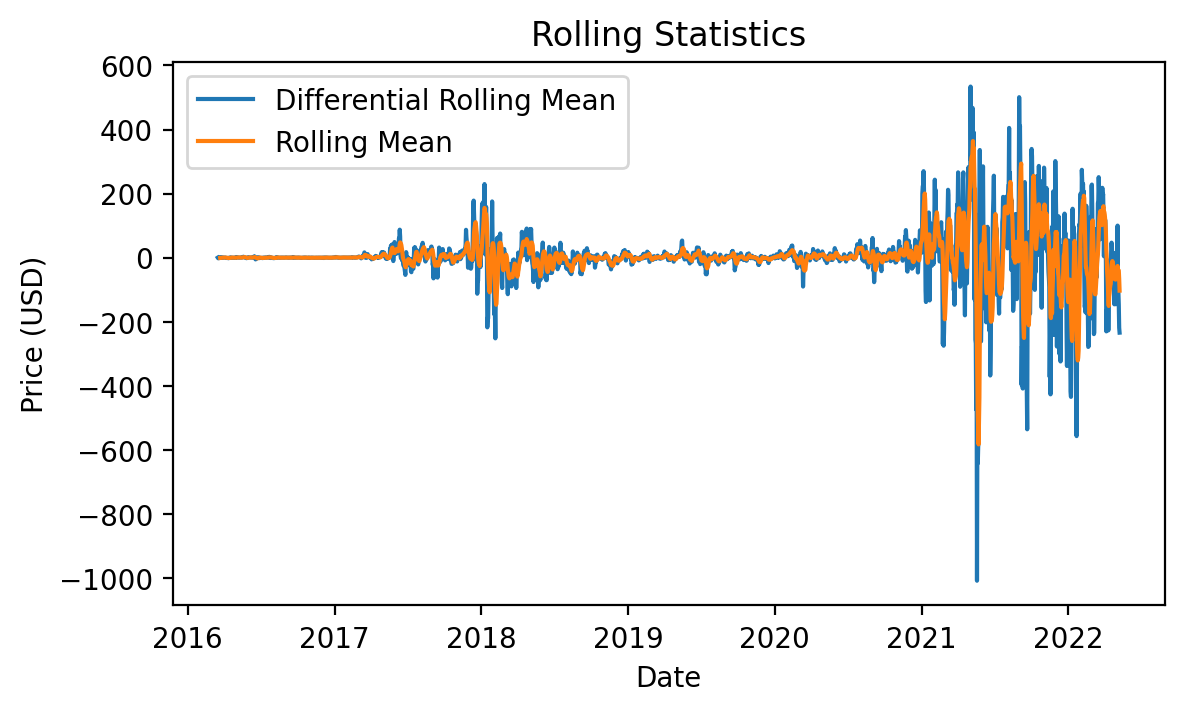

In [277]:
diff_rolling_mean_repeat = diff_rolling_mean.rolling(window=7).mean().dropna()
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(diff_rolling_mean, label="Differential Rolling Mean")
plt.plot(diff_rolling_mean_repeat, label="Rolling Mean")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Rolling Statistics")
plt.show()

In [278]:
diff_ewm = (ether_data_close - exp_w_mean).dropna()
diff_ewm

,Close
Date,
2016-03-10,0.000000
2016-03-11,0.085714
2016-03-12,0.599189
2016-03-13,1.743771
2016-03-14,-0.555403
...,...
2022-05-05,-85.201117
2022-05-06,-104.835838
2022-05-07,-121.264378


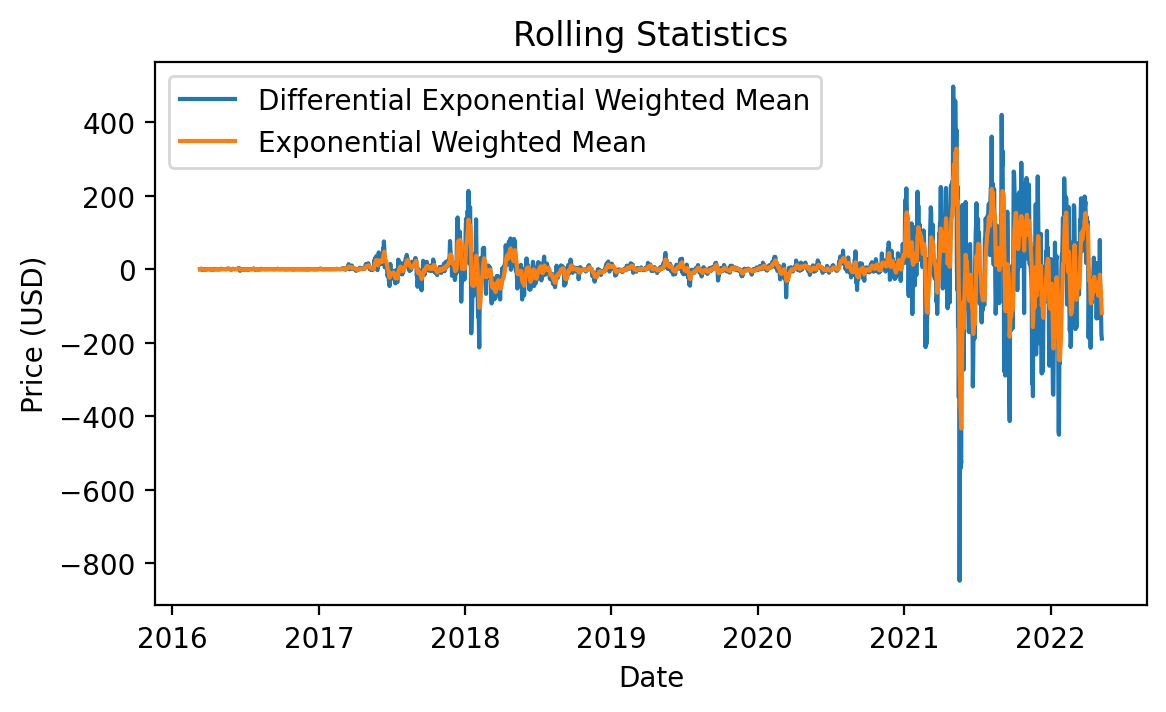

In [279]:
diff_ewm_repeat = diff_ewm.ewm(span=7).mean()
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(diff_ewm, label="Differential Exponential Weighted Mean")
plt.plot(diff_ewm_repeat, label="Exponential Weighted Mean")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Rolling Statistics")
plt.show()

In [280]:
test_stationarity(diff_rolling_mean)

Dicky Fuller Test Results:
Statistics             -9.441937e+00
p-value                 4.868422e-16
Lags                    2.000000e+01
Observations            2.225000e+03
Critical Value (1%)    -3.433292e+00
Critical Value (5%)    -2.862840e+00
Critical Value (10%)   -2.567462e+00
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_13516\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


In [281]:
test_stationarity(diff_ewm)

Dicky Fuller Test Results:
Statistics             -8.656465e+00
p-value                 4.953597e-14
Lags                    2.000000e+01
Observations            2.231000e+03
Critical Value (1%)    -3.433284e+00
Critical Value (5%)    -2.862836e+00
Critical Value (10%)   -2.567460e+00
dtype: float64


C:\Users\samee\AppData\Local\Temp\ipykernel_13516\2986207081.py:4: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  output = pd.Series(results[:4], index=["Statistics", "p-value", "Lags", "Observations"]).append(pd.Series({"Critical Value (%s)" % key: value for key, value in results[4].items()}))


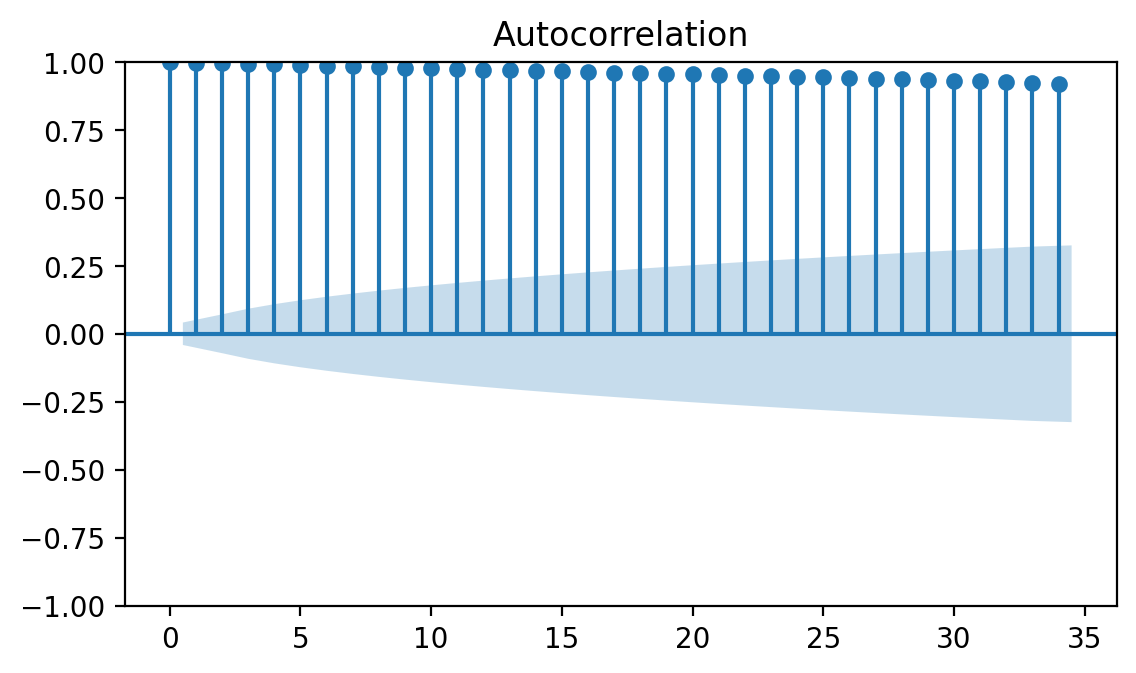

In [282]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plot_acf(ether_data_close, ax=plt.gca())
plt.show()

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


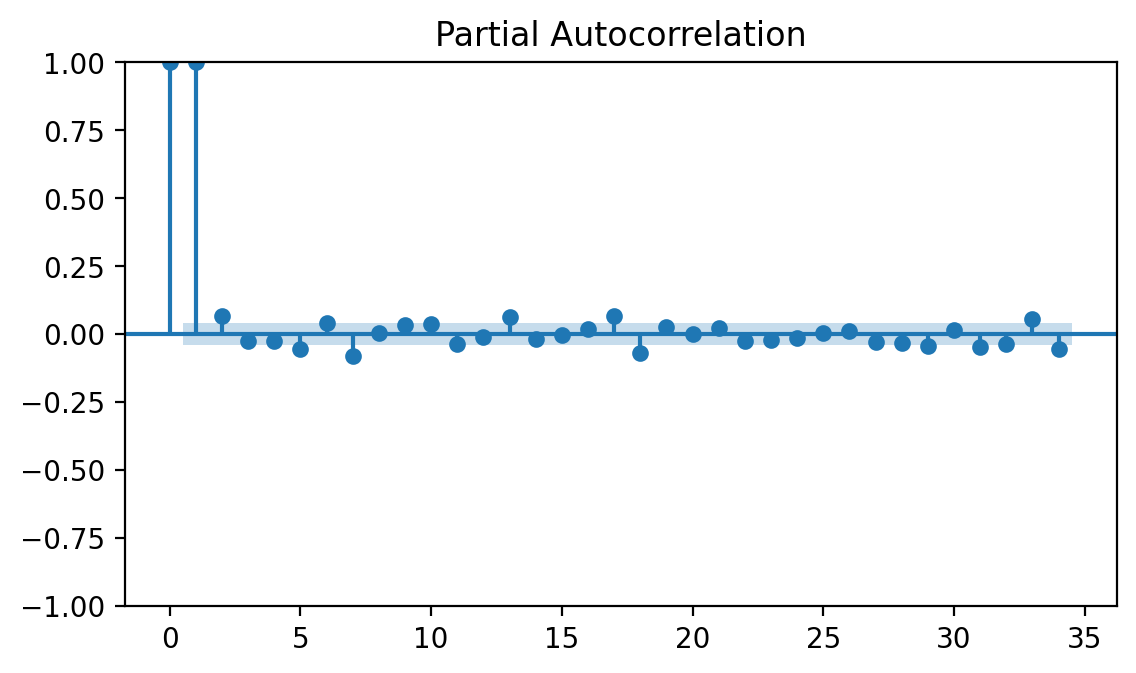

In [283]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plot_pacf(ether_data_close, ax=plt.gca())
plt.show()

In [284]:
training_size = int(len(diff_rolling_mean) * 0.90)
test_size = len(diff_rolling_mean) - training_size
train_ether_data = ether_data_close[:training_size]
test_ether_data = ether_data_close[training_size:]

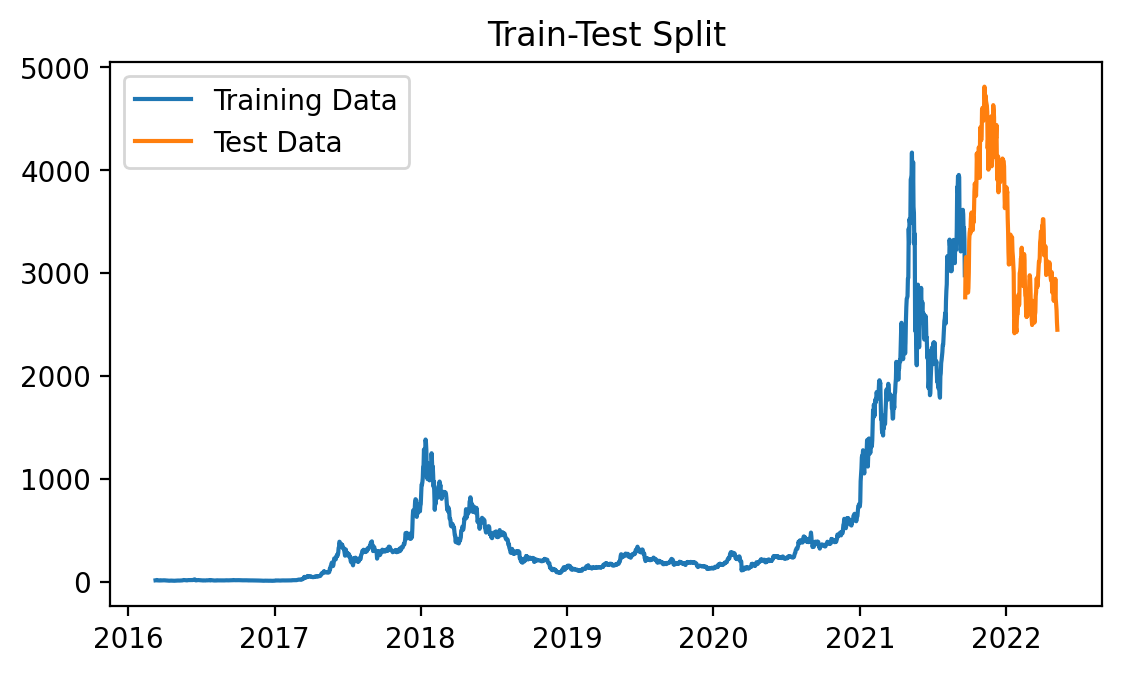

In [285]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(train_ether_data, label = "Training Data")
plt.plot(test_ether_data, label = "Test Data")
plt.title('Train-Test Split')
plt.legend()
plt.show()

In [286]:
auto_arima = auto_arima(train_ether_data["Close"], trace=True, error_action='ignore', suppress_warnings=True, seasonal=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=22010.006, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=22063.106, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=22032.157, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=22038.264, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=22062.450, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=22009.168, Time=0.80 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=22009.692, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=22009.598, Time=0.88 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=22010.867, Time=0.89 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=22008.868, Time=0.60 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=22010.863, Time=0.78 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=21989.113, Time=2.03 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=21902.473, Time=3.04 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=21931.913, Time=2.18 sec
 ARIMA(3,1,4)(0,0,0

In [287]:
auto_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2021
Model:               SARIMAX(3, 1, 4)   Log Likelihood              -10926.361
Date:                Wed, 11 May 2022   AIC                          21868.722
Time:                        08:50:32   BIC                          21913.609
Sample:                             0   HQIC                         21885.196
                               - 2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2574      0.019    -64.682      0.000      -1.296      -1.219
ar.L2         -1.2863      0.018    -73.394      0.000      -1.321      -1.252
ar.L3         -0.6546      0.019    -34.077      0.000      -0.692      -0.617
ma.L1          1.1593      0.023     50.293      0.000       1.114       1.204
ma.L2          1.3279      0.017     77.774      0.000       1.294       1.361
ma.L3          0.7424      0.023     32.098      0.000       0.697       0.788
ma.L4          0.1595      0.009     18.619      0.000       0.143       0.176
sigma2      2921.5130     21.853    133.692      0.000    2878.683    2964.343
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):            173592.34
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              21.76   Skew:                            -1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                        48.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

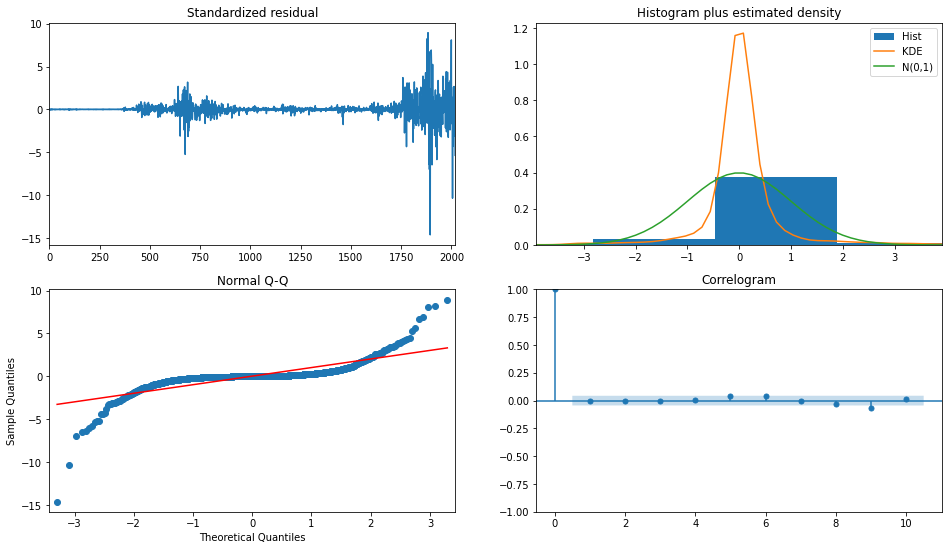

In [288]:
auto_arima.plot_diagnostics(figsize=(16, 9))
plt.show()

In [289]:
arima_model = SARIMAX(train_ether_data["Close"], order=(3, 1, 4), seasonal_order=(1,1,1,30))
fitted_arima = arima_model.fit()
fitted_arima.summary()

c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\samee\Projects\Thesis\venv-ether\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Close   No. Observations:                 2021
Model:             SARIMAX(3, 1, 4)x(1, 1, [1], 30)   Log Likelihood              -10840.172
Date:                              Wed, 11 May 2022   AIC                          21700.345
Time:                                      08:53:15   BIC                          21756.304
Sample:                                  03-10-2016   HQIC                         21720.897
                                       - 09-20-2021                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2279      0.022    -55.566      0.000      -1.271      -1.185
ar.L2         -1.3510      0.011   -126.092      0.000      -1.372      -1.330
ar.L3         -0.7181      0.022    -33.294      0.000      -0.760      -0.676
ma.L1          1.0970      0.026     41.514      0.000       1.045       1.149
ma.L2          1.3464      0.014     94.039      0.000       1.318       1.375
ma.L3          0.6662      0.026     25.270      0.000       0.615       0.718
ma.L4          0.0695      0.010      6.987      0.000       0.050       0.089
ar.S.L30       0.0674      0.014      4.739      0.000       0.040       0.095
ma.S.L30      -0.9946      0.037    -26.625      0.000      -1.068      -0.921
sigma2      2978.3351     95.946     31.042      0.000    2790.283    3166.387
===================================================================================
Ljung-Box (L1) (Q):                   1.15   Jarque-Bera (JB):            190775.54
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):              11.53   Skew:                            -1.60
Prob(H) (two-sided):                  0.00   Kurtosis:                        50.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [290]:
predicted = fitted_arima.forecast(225, alpha=0.05)
forecast = pd.Series(predicted, index=test_ether_data.index)
actual = test_ether_data

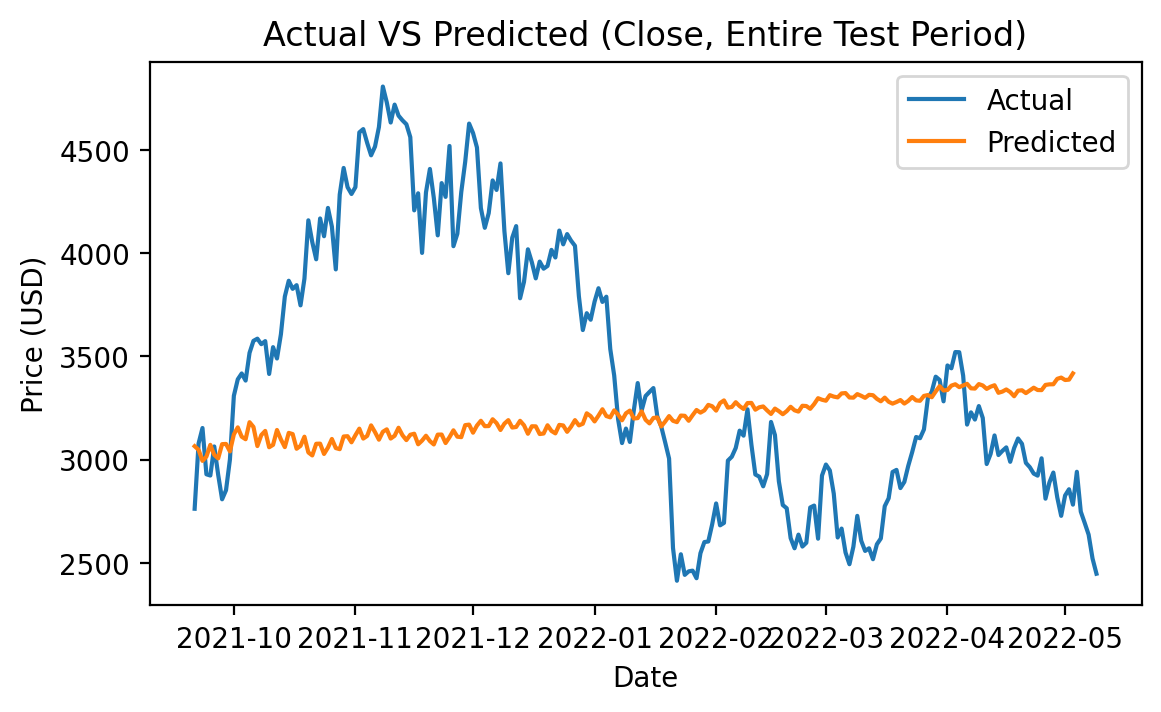

In [291]:
plt.figure(figsize=(6.40, 3.60), dpi=200)
plt.plot(actual, label="Actual")
plt.plot(predicted, label="Predicted")
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Actual VS Predicted (Close, Entire Test Period)")
plt.show()

In [292]:
train = np.random.rand(90)
test = np.random.rand(10)
m = SARIMAX(train, order=(1, 1, 1))
fa = m.fit(disp=-1)
fa.summary()
p = fa.forecast(10, alpha=0.05)
p

array([0.48925536, 0.45144467, 0.45450328, 0.45425586, 0.45427587,
       0.45427425, 0.45427438, 0.45427437, 0.45427437, 0.45427437])